In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Robert_Bosch/dataset/Test_data/
# %ls 
# # %mkdir -p dataset
# !pip install ipdb
# # !unzip Test_data.zip -d dataset

In [3]:
%ls

'eff-ns-b7_focal[Training].ipynb'   Robet_Bosch_Viper-Triplet.ipynb   Train/
 lightning_logs/                    Sample_Submission.csv             Val/
 Robet_Bosch_Viper.ipynb            Test/                             weights/


In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipdb 
import pandas as pd
import os
os.chdir('./')
train_test_val = 0
dataset = []
k_fold = True
folders_to_look = ['Train/','Val/'] if k_fold==True else ['Train/']
classes = [cl.split('/')[1] for cl in glob.glob('Train/'+'/*')] #Class names
cls_len = len(glob.glob('Train/'+'/*')) #Number of Classes in the dataset

for folder in glob.iglob('*/'):
  if(train_test_val == 0):
    if(folder in folders_to_look):
      for classess in glob.glob(folder+'/*'):
        for files in glob.iglob(classess+"/*.jpg"):
          img_path = files
          class_id = classes.index(files.split('/')[1])
          dataset.append((img_path,class_id))

df = pd.DataFrame(dataset,columns=['image_path','class'])
# dataset = np.asarray(dataset)
train_df, val_df = df.iloc[:970],df.iloc[970:]
print("Data Points:")
print("Train:",len(train_df),"Test:",len(val_df))


#Checking for Class Imbalance
cls, counts = np.unique(train_df['class'].values, return_counts=True)
# print([print("class:",classes[cls[i]],"counts:",counts[i]) for i in range(cls_len)])
# Hence no class imbalance


Data Points:
Train: 970 Test: 2910


In [5]:
#k-Fold Validation

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=6)
skf.get_n_splits(len(df))
fold = 0
df['fold'] =0 
for train_index, test_index in skf.split(df['image_path'],df['class']):
    df['fold'].loc[test_index]=fold
    fold+=1
    

/data/sathya/anaconda3/envs/pytorch/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:

import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class vdataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transforms = transform
    def __len__(self):
        return len(self.df)
    
    def read_image(self, image_path):
        image = cv2.imread(image_path)
        image = (image-np.min(image))/(np.max(image)-np.min(image))
        image = np.rollaxis(image,-1,0).astype(np.float32)
        return image
        
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        image_path, label = data['image_path'], data['class']
        image = self.read_image(image_path)
        

        if self.transforms:
            image = self.transforms(image)

        return torch.tensor(image),torch.tensor(label)

viper_dataset = vdataset(train_df[['image_path','class']])
    

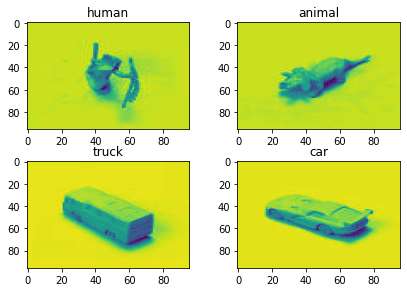

In [9]:
fig, axs = plt.subplots(2,2)
fig.tight_layout()
cls_ind = 0
for i in range(2):
    for j in range(2):
        test_sample,cls = viper_dataset.__getitem__(194*cls_ind+1)
        axs[i][j].imshow(test_sample[0,:],aspect='auto')
        axs[i][j].set_title(classes[cls])
        cls_ind+=1
plt.show()

In [8]:
train_dataset = vdataset(train_df)
val_dataset = vdataset(val_df)

train_dataloader = DataLoader(train_dataset, batch_size=8*4*4,
                        shuffle=True, num_workers=0)

val_dataloader = DataLoader(val_dataset, batch_size=8*4*4,
                        shuffle=True, num_workers=0)

In [9]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def conv_res(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class res_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(res_block, self).__init__()
        self.conv1 = conv_res(in_channels, out_channels, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv_res(out_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn(self.conv1(x)))
        out = self.bn1(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class res_net(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(res_net, self).__init__()
        self.in_channels = 16
        self.conv = conv_res(3, 8)
        self.conv1 = conv_res(8, 16)
        self.bn = nn.BatchNorm2d(8)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc1 = nn.Linear(576, 64)
        self.fc2 = nn.Linear(64, num_classes)

        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv_res(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.relu(self.bn1(self.conv1(out)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    
resnet = res_net(res_block, [4, 16, 16*2], num_classes=len(classes))
from torchsummary import summary
summary(resnet,(3,96,96))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 96, 96]           216
├─BatchNorm2d: 1-2                       [-1, 8, 96, 96]           16
├─ReLU: 1-3                              [-1, 8, 96, 96]           --
├─Conv2d: 1-4                            [-1, 16, 96, 96]          1,152
├─BatchNorm2d: 1-5                       [-1, 16, 96, 96]          32
├─ReLU: 1-6                              [-1, 16, 96, 96]          --
├─Sequential: 1-7                        [-1, 16, 96, 96]          --
|    └─res_block: 2-1                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 96, 96]          32
|    |    └─ReLU: 3-3                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 96, 96]          32
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 96, 96]           216
├─BatchNorm2d: 1-2                       [-1, 8, 96, 96]           16
├─ReLU: 1-3                              [-1, 8, 96, 96]           --
├─Conv2d: 1-4                            [-1, 16, 96, 96]          1,152
├─BatchNorm2d: 1-5                       [-1, 16, 96, 96]          32
├─ReLU: 1-6                              [-1, 16, 96, 96]          --
├─Sequential: 1-7                        [-1, 16, 96, 96]          --
|    └─res_block: 2-1                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 96, 96]          32
|    |    └─ReLU: 3-3                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 96, 96]          32
|    

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from torchcontrib.optim import SWA
from pytorch_lightning.metrics import Metric
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_callback = ModelCheckpoint(
        monitor='valid_acc',
        mode = 'max',
        save_last=True,
        dirpath='weights/normal',
        filename='CE_loss-{epoch:02d}-{valid_acc:.2f}'
    )

class Net(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy()


    def forward(self, x):
        embedding = self.model(x)
        return embedding

    def configure_optimizers(self):
        self.optimizer = SWA(torch.optim.Adam(self.model.parameters(),  lr=1e-8))
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer,
                                                                    T_max=10,
                                                                    eta_min=1e-2,
                                                                    verbose=True)

        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        z = self.model(x)   
        loss = F.cross_entropy(z,y)
        acc = self.accuracy(z, y)
        logs = {'train_loss': loss, 'train_acc': acc, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        z = self.model(x)
        loss = F.cross_entropy(z, y)
        acc = self.accuracy(z, y)
        logs = {'valid_loss': loss, 'valid_acc': acc}
        self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
  
    def training_epoch_end(self, outs):
        self.log('train_acc_epoch', self.accuracy.compute())

# model
model = Net(resnet)

# training
trainer = pl.Trainer(gpus=1,precision=16, max_epochs=100, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader, val_dataloader)
    


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | model    | res_net  | 2.7 M 
1 | accuracy | Accuracy | 0     
--------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.888    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-08.


Validation sanity check: 0it [00:00, ?it/s]

/data/sathya/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/data/sathya/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/sathya/anaconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.
